In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from thor.data.gridrad_website import read_file
from netCDF4 import Dataset
import subprocess
import tempfile
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.track as track
import thor.option as option
import thor.tag as tag
import thor.visualize as visualize

notebook_name = "gridrad_demo.ipynb"
__file__ = "/home/ewan/Documents/THOR/examples/gridrad_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Parent directory for saving outputs
base_local = Path("/home/ewan/THOR_output")
start = "2010-01-20T18:00:00"
end = "2010-01-21T03:30:00"

# Create the data_options dictionary
converted_options = {"save": True, "load": False, "parent_converted": None}
gridrad_options = data.gridrad.gridrad_data_options(
    start=start, end=end, converted_options=converted_options
)
era5_pl_options = data.era5.data_options(start=start, end=end)
era5_sl_options = data.era5.data_options(
    start=start, end=end, data_format="single-levels"
)
data_options = option.consolidate_options(
    [gridrad_options, era5_pl_options, era5_sl_options]
)

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, filename="gridrad_era5")

# Create the grid_options dictionary using the first file in the cpol dataset
grid_options = grid.create_options(
    name="geographic", regrid=False, altitude_spacing=None, geographic_spacing=None
)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, filename="gridrad_geographic")

# Create the tag_options dictionary
era5_pl_tag_options = data.era5.tag_options()
era5_sl_tag_options = data.era5.tag_options(dataset="era5_sl")
tag_options = option.consolidate_options([era5_pl_tag_options, era5_sl_tag_options])
tag.save_tag_options(tag_options, filename="era5")

# Create the track_options dictionary
track_options = option.mcs(dataset="gridrad", tags=["era5_pl", "era5_sl"], global_flow_margin=150, unique_global_flow=False)
option.save_track_options(track_options, filename="gridrad_mcs")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(obj, save=True, style="presentation")
    for obj in ["cell", "mcs"]
}
# visualize_options["middle_cloud"] = visualize.option.runtime_options(
#     "middle_cloud", save=True, style="presentation", figure_types=["mask"]
# )
visualize.option.save_display_options(visualize_options, filename="runtime_mcs")

2024-08-22 10:37:19,061 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/data_options/gridrad_era5.yaml
2024-08-22 10:37:19,084 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/grid_options/gridrad_geographic.yaml
2024-08-22 10:37:19,090 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/tag_options/era5.yaml
2024-08-22 10:37:19,095 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/track_options/gridrad_mcs.yaml
2024-08-22 10:37:19,113 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/visualize_options/runtime_mcs.yaml


In [3]:
file = data_options["gridrad"]["filepaths"][35]

In [8]:
# import cProfile
# import pstats
# from io import StringIO
# pr = cProfile.Profile()
# pr.enable()

ds = data.gridrad.open_gridrad(file)
ds = data.gridrad.filter(ds, refl_thresh=-10)
ds = data.gridrad.remove_clutter(ds)
# pr.disable()
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

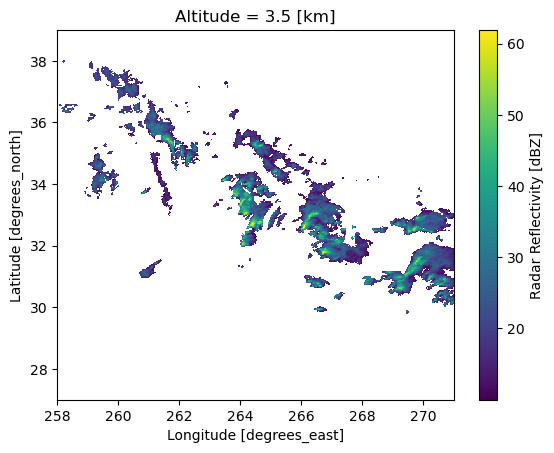

In [9]:
ds["Reflectivity"].isel(Altitude=6).plot()

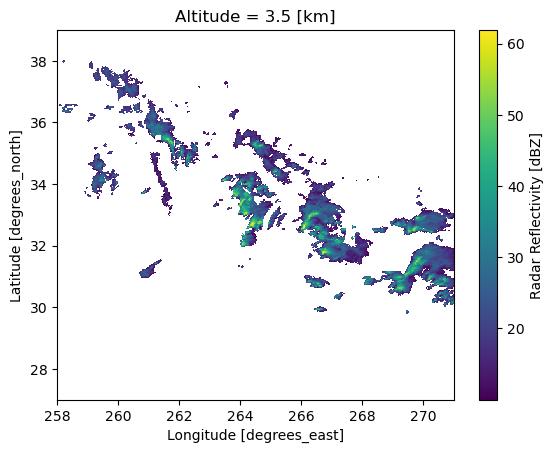

In [130]:
ds["Reflectivity"].isel(Altitude=6).plot()

In [58]:
from functools import reduce

In [59]:
cond = reduce(np.logical_or, [exists_4, ~exists_above_4, ~exists_below_4])

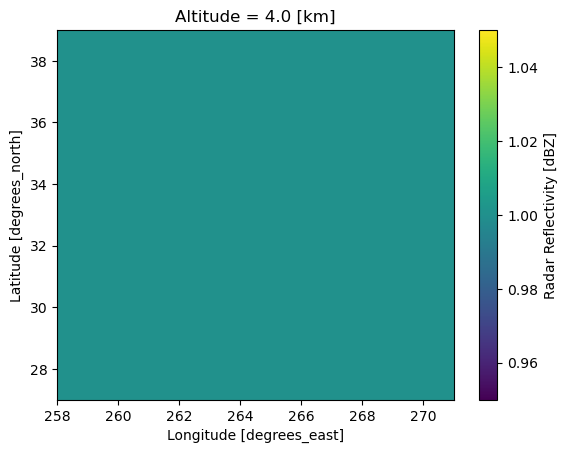

In [61]:
cond.plot()

In [51]:
~exists_above_4 | ~exists_below_4

<xarray.DataArray 'Reflectivity' (Latitude: 576, Longitude: 624)> Size: 359kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * Longitude  (Longitude) float64 5kB 258.0 258.0 258.1 ... 270.9 271.0 271.0
  * Latitude   (Latitude) float64 5kB 27.01 27.03 27.05 ... 38.95 38.97 38.99

In [57]:
ds = data.gridrad.remove_clutter_below_anvils(ds)

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [16]:
# Find clutter below convective anvils. Idea appears to be to remove column if no data exists at 4 km, but data exists elsewhere
data0 = ds
k4km = ((np.where(data0.Altitude >= 4.0))[0])[0]
fin = np.isfinite(data0.Reflectivity)
ibad = np.where(
    (fin[k4km, :, :] == False)
    & (np.sum(fin[k4km:, :, :], axis=0) > 0)
    & (np.sum(fin[0:k4km, :, :], axis=0) > 0)
)  # edited here bc python counting (1:5 = 1,2,3,4)
nbad = len(ibad[0])
if nbad > 0:
    kbad = (np.zeros((nbad))).astype(int)
    for k in range(0, k4km + 1):
        data0["Reflectivity"].values[(k + kbad), ibad[0], ibad[1]] = np.nan

In [31]:
refl_exists = np.isfinite(ds.Reflectivity)
refl_exists_4 = refl_exists.where(ds.Altitude > 4.0, drop=True).isel(Altitude=0)
refl_exists_4

<xarray.DataArray 'Reflectivity' (Latitude: 576, Longitude: 624)> Size: 3MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])
Coordinates:
  * Longitude  (Longitude) float64 5kB 258.0 258.0 258.1 ... 270.9 271.0 271.0
  * Latitude   (Latitude) float64 5kB 27.01 27.03 27.05 ... 38.95 38.97 38.99
    Altitude   float64 8B 4.5
Attributes:
    long_name:  Radar Reflectivity
    units:      dBZ

In [44]:
exists = np.isfinite(ds.Reflectivity)
exists_above_4 = exists.where(ds.Altitude >= 4.0, drop=True)
exists_4 = exists_above_4.isel(Altitude=0)
exists_above_4 = exists_above_4.sum(dim="Altitude") > 0
exists_below_4 = exists.where(ds.Altitude < 4.0, drop=True).sum(dim="Altitude") > 0

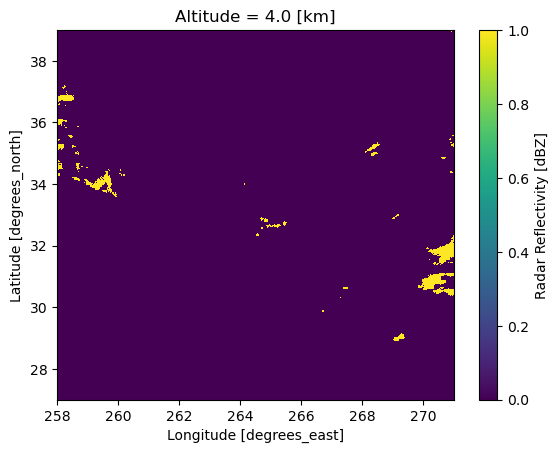

In [46]:
exists_4.plot()

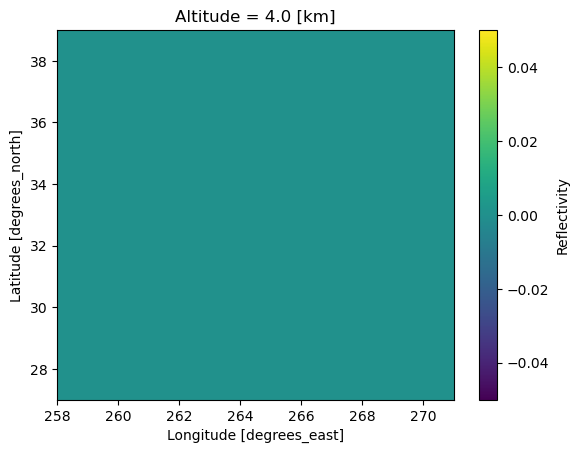

In [26]:
(
    (fin[k4km, :, :] == False)
    & (np.sum(fin[k4km:, :, :], axis=0) > 0)
    & (np.sum(fin[0:k4km, :, :], axis=0) > 0)
).plot()  

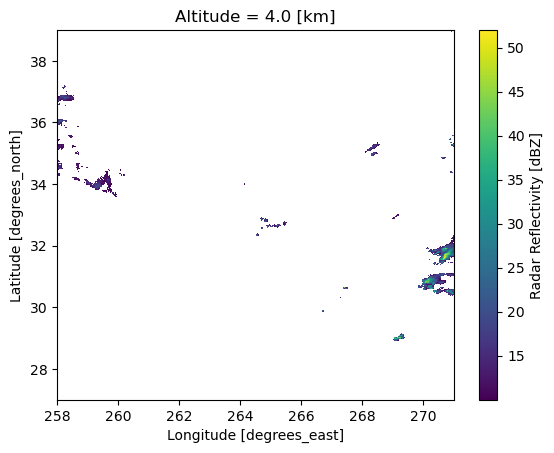

In [21]:
data0["Reflectivity"].isel(Altitude=7).plot()

In [251]:
(np.sum(fin[k4km:, :, :], axis=0) > 0)

<xarray.DataArray 'Reflectivity' (Latitude: 576, Longitude: 624)> Size: 359kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]])
Coordinates:
  * Longitude  (Longitude) float64 5kB 258.0 258.0 258.1 ... 270.9 271.0 271.0
  * Latitude   (Latitude) float64 5kB 27.01 27.03 27.05 ... 38.95 38.97 38.99

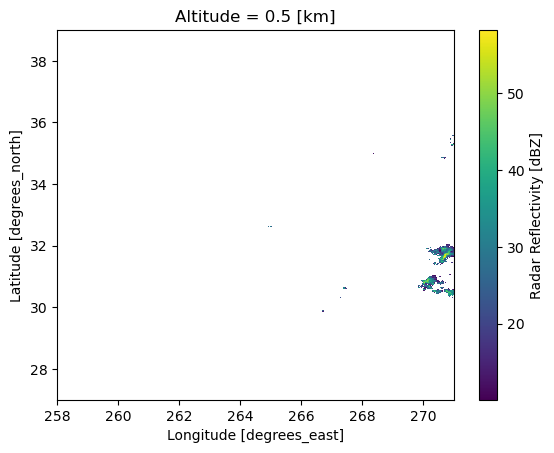

In [248]:
data0["Reflectivity"].isel(Altitude=0).plot()